# Predicting Bike Rentals in Washington, DC
Many U.S. cities have bike rental programs that allow individuals to rent bikes by the hour. Washington, D.C. has such a program, and the city collects data on the number of users each hour. The data is available [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), and the goal of this project is to predict the number of bikes rented in a particular hour.  

## Exploring the Data

In [808]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
%matplotlib inline

In [809]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [810]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


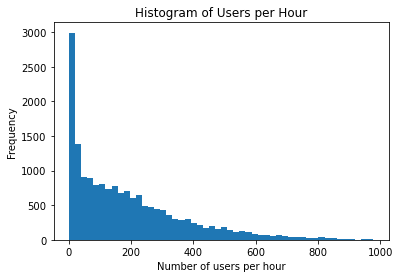

In [811]:
plt.hist(bike_rentals['cnt'], bins=50)
plt.xlabel('Number of users per hour')
plt.ylabel('Frequency')
plt.title('Histogram of Users per Hour')
plt.show()

Here, we see that most hours have a low number of users. This could be because uptake was slow in the early years of the program. It could also be because there are likely few users during night hours. 

In [812]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Above, we see the columns with the strongest correlation to 'cnt' (which is the number of users an hour). The high correlation of the 'registered' and 'casual' columns is because they are the  subsets of 'cnt' that correspond to registered and unregistered users. Besides these columns, we see that columns corresponding to temperature, hour, and year have a high correlation. 

## Creating Features

### Hours

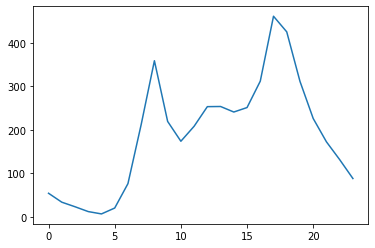

In [813]:
plt.plot(bike_rentals.groupby('hr')['cnt'].mean())
plt.show()

In [814]:
bike_rentals.groupby('hr')['cnt'].mean()

hr
0      53.898072
1      33.375691
2      22.869930
3      11.727403
4       6.352941
5      19.889819
6      76.044138
7     212.064649
8     359.011004
9     219.309491
10    173.668501
11    208.143054
12    253.315934
13    253.661180
14    240.949246
15    251.233196
16    311.983562
17    461.452055
18    425.510989
19    311.523352
20    226.030220
21    172.314560
22    131.335165
23     87.831044
Name: cnt, dtype: float64

In [815]:
def assign_label(hour):
    if hour >= 23 or hour <= 6:
        return 'night'
    elif (hour >= 16 and hour <= 19) or (hour == 8):
        return 'rush-hour'
    else:
        return 'other-time'

In [816]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [817]:
bike_rentals['time_label'] = pd.Categorical(bike_rentals['time_label'])

In [818]:
bike_rentals = pd.concat([bike_rentals.drop('time_label',axis=1), pd.get_dummies(bike_rentals['time_label'], drop_first=True)], axis=1)

In [819]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,other-time,rush-hour
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,0


### Temperature

In [820]:
bins = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

In [821]:
bike_rentals.groupby(pd.cut(bike_rentals['temp'], bins=bins))['cnt'].mean()

temp
(0.0, 0.1]     42.290598
(0.1, 0.2]     67.865687
(0.2, 0.3]     92.832242
(0.3, 0.4]    148.433574
(0.4, 0.5]    175.885327
(0.5, 0.6]    211.700075
(0.6, 0.7]    225.333651
(0.7, 0.8]    317.066296
(0.8, 0.9]    330.774400
(0.9, 1.0]    292.809524
Name: cnt, dtype: float64

In [822]:
def temp_cats(temp):
    if temp <= .3:
        return 'bad-temp'
    elif temp <= .7:
        return 'okay-temp'
    else:
        return 'great-temp'

In [823]:
bike_rentals['temp_cats'] = bike_rentals['temp'].apply(temp_cats)

In [824]:
bike_rentals['temp_cats'] = pd.Categorical(bike_rentals['temp_cats'])
bike_rentals = pd.concat([bike_rentals.drop('temp_cats',axis=1), pd.get_dummies(bike_rentals['temp_cats'], drop_first=True)],axis=1)

In [825]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,other-time,rush-hour,great-temp,okay-temp
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0,0,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,0,0,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,0,0,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,0,0,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,0,0,0


## Choosing an Evaluation Metric
For this project, we will use the root mean squared error metric as we are predicted a continuous quantity (the number of users).

## Dividing the Data into Testing and Training Sets

In [826]:
train = bike_rentals.sample(frac=.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [827]:
train.shape

(13903, 21)

In [828]:
test.shape

(3476, 21)

## Linear Regression

In [829]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [830]:
def model_my_data(model):
    model.fit(train[predicting_cols], train['cnt'])
    predictions = model.predict(test[predicting_cols])
    rmse = mean_squared_error(test['cnt'], predictions, squared=False)
    return rmse

In [831]:
predicting_cols = list(train.columns)

In [832]:
for col in ['cnt','casual', 'registered','dteday','instant','atemp']:
    predicting_cols.remove(col)

In [833]:
predicting_cols

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'other-time',
 'rush-hour',
 'great-temp',
 'okay-temp']

In [834]:
model_my_data(LinearRegression())

110.31393391119212

The error for our linear regression model is relatively high. This could be because there are other factors driving bike rental rates that are not captured in the available data. For instance, it could be that the bike rental service offers promotions at certain times to drive up ridership, or ridership could increase when there are large delays on the metro. 

## Decision Tree 

In [835]:
from sklearn.tree import DecisionTreeRegressor

In [836]:
rmse_vals = []
for i in range(1, 51):
    rmse_vals.append(model_my_data(DecisionTreeRegressor(min_samples_leaf=i)))

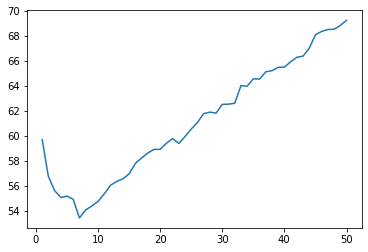

In [837]:
plt.plot(range(1,51),rmse_vals)

In [838]:
print('min_samples_leaf: {}. RMSE Value: {}'.format(rmse_vals.index(min(rmse_vals))+1, min(rmse_vals)))

min_samples_leaf: 7. RMSE Value: 53.47494344193842


Above, we see that our decision tree model had the lowest rmse value when 'min_samples_leaf' was set to 12, and that this RMSE value was 90.4. 

## Random Forest

In [839]:
from sklearn.ensemble import RandomForestRegressor

In [840]:
rmse_vals = []
for i in range(1,11):
    rmse = model_my_data(RandomForestRegressor(n_estimators=50, min_samples_leaf=i, random_state=1))
    rmse_vals.append(rmse)

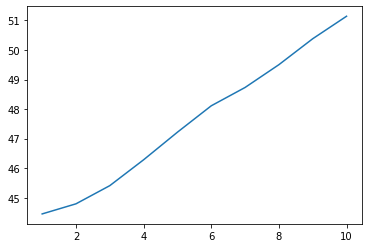

In [841]:
plt.plot(range(1,11),rmse_vals)

In [842]:
print('min_samples_leaf: {}. RMSE Value: {}'.format(rmse_vals.index(min(rmse_vals))+1, min(rmse_vals)))

min_samples_leaf: 1. RMSE Value: 44.45093768033804


Above, we see that the random forest brings a small improvement over using a single decision tree. 